### Note : This notebook is inspired from this [example script](https://github.com/Farama-Foundation/HighwayEnv/blob/master/scripts/parking_her.ipynb)

## Setup and imports

In [1]:
import gymnasium as gym
import pprint
from stable_baselines3 import HerReplayBuffer, SAC
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import os

env = gym.make("parking-v0", render_mode="rgb_array")
env.reset()

print(env.spec)
pprint.pprint(env.config)

c:\Users\adrie\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'utils'

Action space: Box(-1.0, 1.0, (2,), float32)
Observation space: Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))


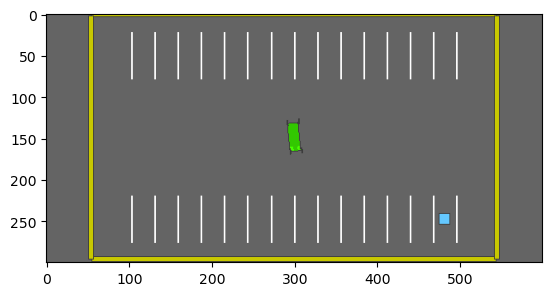

In [20]:
action_space = env.action_space
observation_space = env.observation_space

print(f"Action space: {action_space}")
print(f"Observation space: {observation_space}")

plt.imshow(env.render())
plt.show()

## Train the agent

In [21]:
class FlattenObservation(gym.Wrapper):
    def _init_(self, env: gym.Env):
        super()._init_(env)

    def observation(self, observation: np.ndarray) -> np.ndarray:
        return observation.flatten()

STEPS = 300 # 1e5
env_train = FlattenObservation(deepcopy(env))
her_kwargs = dict(n_sampled_goal=4, goal_selection_strategy='future')
model = SAC('MultiInputPolicy', env_train, replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=her_kwargs, verbose=1,
            tensorboard_log=os.path.join("test", "train_hrb_sac_3x256"),
            learning_rate=1e-3,
            gamma=0.95, batch_size=1024, tau=0.05,
            learning_starts=1000,  
            device="cpu")

model.learn(total_timesteps=int(STEPS))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to test\train_hrb_sac_3x256\SAC_1


## Visualise episodes and save video

The two following cells are different implementations of the same objective : create a video and save

In [6]:
import gymnasium as gym
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

env_id = "parking-v0"
video_folder = "logs/videos/"
video_length = 100

vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")]) # creates the environment in default configuration !!!

obs = vec_env.reset()

# Record the video starting at the first step
vec_env = VecVideoRecorder(vec_env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"random-agent-{env_id}")

vec_env.reset()
for _ in range(video_length + 1):
  action, _ = model.predict(obs, deterministic=True)
  action = [np.array(action.squeeze(), dtype=np.float32)]
  obs, _, _, _ = vec_env.step(action)
# Save the video
vec_env.close()

NameError: name 'model' is not defined

In [5]:
#@title Visualize a few episodes

import base64
from pathlib import Path

from gymnasium.wrappers import RecordVideo
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()


def record_videos(env, video_folder="videos"):
    wrapped = RecordVideo(
        env, video_folder=video_folder, episode_trigger=lambda e: True
    )

    # Capture intermediate frames
    env.unwrapped.set_record_video_wrapper(wrapped)

    return wrapped


def show_videos(path="videos"):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

N_EPISODES = 10  # @param {type: "integer"}

env = gym.make('parking-v0', render_mode='rgb_array')
env = record_videos(env)
for episode in trange(N_EPISODES, desc="Test episodes"):
    obs, info = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable